In [43]:
pip install streamlit

  Using cached streamlit-1.26.0-py2.py3-none-any.whl (8.1 MB)
  Using cached cachetools-5.3.1-py3-none-any.whl (9.3 kB)
  Using cached altair-5.1.1-py3-none-any.whl (520 kB)
  Using cached importlib_metadata-6.8.0-py3-none-any.whl (22 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
  Using cached blinker-1.6.2-py3-none-any.whl (13 kB)
  Using cached pydeck-0.8.0-py2.py3-none-any.whl (4.7 MB)
     -------------------------------------- 189.5/189.5 kB 3.9 MB/s eta 0:00:00
  Using cached tzlocal-4.3.1-py3-none-any.whl (20 kB)
  Using cached rich-13.5.2-py3-none-any.whl (239 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached jsonschema-4.19.0-py3-none-any.whl (83 kB)
  Using cached gitdb-4.0.10-py3-none-any.whl (62 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
  Using cached MarkupSafe-2.1.3-cp310-cp310-win_amd64.whl (17 kB)
  Using cached referencing-0.30.2-py3-none-any.whl (25 kB)
  Using cached jsonschema_specifications-2023.7.1-py3-none-


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: C:\Users\Edison Yi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [296]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
matplotlib.rcParams["axes.formatter.limits"] = (-99, 99)

In [401]:
def calculate_percentiles(arr, capital_invested):
    """
    Calculate the 10th, 25th, 50th (median), 75th, 90th, and the percentile of the value closest to 0 in an array.
    Also, add a column that represents the values as a percentage of capital invested.

    Args:
    arr (list or numpy.ndarray): Input array.
    capital_invested (float): The amount of capital invested.

    Returns:
    pandas.DataFrame: A DataFrame with percentiles and value as a percentage of capital invested.
    """
    if not isinstance(arr, (list, np.ndarray)):
        raise ValueError("Input must be a list or numpy.ndarray")

    percentiles = [10, 25, 50, 75, 90]
    percentile_values = np.percentile(arr, percentiles)

    # Find the value closest to 0
    closest_value = min(arr, key=lambda x: abs(x - 0))

    # Calculate the percentile of the closest value
    sorted_arr = np.sort(arr)
    index_of_closest = np.where(sorted_arr == closest_value)[0][0]
    closest_percentile = (index_of_closest / (len(sorted_arr) - 1)) * 100

    # Create the DataFrame with the "Value as % of Capital" column
    data = {
        'Percentile': percentiles + [closest_percentile],
        'NPV': np.append(percentile_values, closest_value)
    }

    df = pd.DataFrame(data)
    df['% return'] = (df['NPV'] / capital_invested) * 100

    return df

def bin_continuous_features(df, bin_config):
    """
    Encode continuous features into bins and add them as new columns to the DataFrame.

    Parameters:
    - df: pandas DataFrame
        The DataFrame containing the continuous features.
    - bin_config: dict
        A dictionary specifying the binning configuration for each feature.
        Example: {'feature1': [0, 10, 20, 30], 'feature2': [0, 5, 10]}

    Returns:
    - df: pandas DataFrame
        The DataFrame with binned features added as new columns.
    """

    for feature, bins in bin_config.items():
        # Create a new column with the binned values
        df[f'{feature}_bin'] = pd.cut(df[feature], bins=bins, labels=False)

    return df


In [2]:
def get_stamp_duty_next_home(HOUSE_PRICE):
    if HOUSE_PRICE <=250000:
        return 0
    elif HOUSE_PRICE <=925000:
        return (HOUSE_PRICE-250000) * 0.05
    elif HOUSE_PRICE <=1500000:
        return (HOUSE_PRICE-925000) * 0.10 + (925000-250000) * 0.05
    else:
        return (HOUSE_PRICE-1500000) * 0.12 + (925000-250000) * 0.05 + (1500000-925000) * 0.10
    
def annuity_pv(payment, discount_rate, n_periods, growth_rate):
    pv = 0
    for i in range(1, n_periods+1):
        pv += payment*(1+growth_rate)**(i-1) /(1+discount_rate)**(i)
    return pv

def annuity_fv(payment, discount_rate, n_periods, growth_rate):
    pv = 0
    for i in range(1, n_periods+1):
        pv += payment*(1+growth_rate)**(i-1) *(1+discount_rate)**(n_periods-i)
    return pv

def annuity_payment(pv, discount_rate, n_periods, growth_rate):
    return pv* (discount_rate - growth_rate) / (1- (1+growth_rate)**n_periods * (1+discount_rate)**(-1*n_periods))


def pv_future_payment(payment, discount_rate, n_periods):
    return payment/(1+discount_rate)**(n_periods)

def fv_present_payment(payment, discount_rate, n_periods):
    return payment*(1+discount_rate)**(n_periods)

In [3]:
annuity_fv(100,0.02,10,0.01)

1143.7229458355264

In [41]:
class Buy_or_Rent_Model():
    def __init__(self) -> None:
        # PARAMS
        # Fixed (in expectation)
        self.HOUSE_PRICE = 800000 #including upfront repairs and renovations 
        self.RENTAL_YIELD = 0.043 # assumed rent as a proportion of house price https://www.home.co.uk/company/press/rental_yield_heat_map_london_postcodes.pdf
        self.DEPOSIT_MULT = 0.5
        self.MORTGAGE_LENGTH = 30
        self.BUYING_COST_FLAT = 3000 #https://www.movingcostscalculator.co.uk/calculator/
        self.SELLING_COST_MULT = 0.02 #https://www.movingcostscalculator.co.uk/calculator/
        self.ONGOING_COST_MULT = 0.006 # service charge + repairs, council tax and bills are omitted since they are the same whether buying or renting
        # Probability distribution
        self.rent_increase = 0.01325 # historical: https://www.ons.gov.uk/economy/inflationandpriceindices/bulletins/indexofprivatehousingrentalprices/april2023
        self.property_price_growth_annual = 0.025 # historical average = 0.034 over the last 8 year, adjusted down due to end to abnormally low interest rates; source for historical data: https://www.statista.com/statistics/620414/monthly-house-price-index-in-london-england-uk/
        self.mortgage_interest_annual = 0.05
        self.investment_return_annual = 0.06
        self.years_until_sell = 20
        # financial modelling params
        self.inflation = 0.02 #on ongoing costs, also for converting fv

    def run_calculations(self):
        self.monthly_rent = self.HOUSE_PRICE * self.RENTAL_YIELD /12
        self.STAMP_DUTY = get_stamp_duty_next_home(self.HOUSE_PRICE)
        self.discount_rate = self.investment_return_annual
        self.DEPOSIT = self.HOUSE_PRICE * self.DEPOSIT_MULT
        self.future_house_price = self.HOUSE_PRICE * (1+self.property_price_growth_annual)**self.years_until_sell
        self.mortgage_calculations()
        self.get_house_buying_npv()
        self.get_house_buying_fv()
        self.get_renting_fv()

    def mortgage_calculations(self):
        self.mortgage_amount = self.HOUSE_PRICE * (1 - self.DEPOSIT_MULT)
        self.annual_mortgage_payment = annuity_payment(self.mortgage_amount, self.mortgage_interest_annual,self.MORTGAGE_LENGTH,0)
        self.pv_mortage_payments = annuity_pv(self.annual_mortgage_payment, self.discount_rate, self.MORTGAGE_LENGTH, 0)
        self.fv_mortgage_payments = pv_future_payment(annuity_fv(self.annual_mortgage_payment, self.discount_rate, self.MORTGAGE_LENGTH, 0), self.discount_rate, self.MORTGAGE_LENGTH - self.years_until_sell)#annuity_fv(self.annual_mortgage_payment, self.discount_rate, self.MORTGAGE_LENGTH, 0)

    def get_house_buying_npv(self):
        pv_of_future_house_price = pv_future_payment(self.future_house_price, self.discount_rate, self.years_until_sell)
        pv_of_selling_cost = pv_future_payment(self.future_house_price * self.SELLING_COST_MULT, self.discount_rate, self.years_until_sell)
        pv_ongoing_cost = annuity_pv(self.HOUSE_PRICE * self.ONGOING_COST_MULT,self.discount_rate, self.years_until_sell, self.inflation)
        # rent saved
        self.pv_rent_saved = annuity_pv(self.HOUSE_PRICE*self.RENTAL_YIELD, self.discount_rate, self.years_until_sell, self.rent_increase)
        # sum it up
        self.buying_npv = pv_of_future_house_price + self.pv_rent_saved - self.pv_mortage_payments- pv_ongoing_cost - self.DEPOSIT  - self.BUYING_COST_FLAT - self.STAMP_DUTY - pv_of_selling_cost

    def get_house_buying_fv(self): # not accounting for deposit,  immediate costs, and rent saved. ongoing costs and mortgage are rolled up and deducted from fv
        fv_ongoing_cost = annuity_fv(self.HOUSE_PRICE * self.ONGOING_COST_MULT,self.discount_rate, self.years_until_sell, self.inflation)
        self.rent_fv = annuity_fv(self.HOUSE_PRICE*self.RENTAL_YIELD, self.discount_rate, self.years_until_sell, self.rent_increase)
        self.buying_fv = self.future_house_price + self.rent_fv - self.future_house_price * self.SELLING_COST_MULT - fv_ongoing_cost -  self.fv_mortgage_payments
        self.buying_fv_inflation_adjusted = pv_future_payment(self.buying_fv, self.inflation, self.years_until_sell)

    def get_renting_fv(self): # assumes that buying costs and stamp duty are invested, rent is rolled up and deducted
        fv_buying_cost = fv_present_payment(self.BUYING_COST_FLAT, self.discount_rate, self.years_until_sell)
        fv_STAMP_DUTY = fv_present_payment(self.STAMP_DUTY, self.discount_rate, self.years_until_sell)
        deposit_fv = fv_present_payment(self.DEPOSIT, self.discount_rate, self.years_until_sell)
        self.renting_fv = deposit_fv + fv_buying_cost + fv_STAMP_DUTY #- self.rent_fv
        self.renting_fv_inflation_adjusted = pv_future_payment(self.renting_fv, self.inflation, self.years_until_sell)

In [42]:
model = Buy_or_Rent_Model()
model.rent_increase = 0.01325
model.property_price_growth_annual = 0.025 
model.mortgage_interest_annual = 0.05
model.investment_return_annual = 0.08
model.years_until_sell = 20
model.run_calculations()
print(model.buying_npv)
print(model.buying_fv)
print(model.renting_fv)
print(model.buying_fv-model.renting_fv)
print(pv_future_payment(model.buying_fv-model.renting_fv, model.discount_rate, model.years_until_sell))

-130816.84599957103
1396810.3375295922
2006542.0504271272
-609731.712897535
-130816.84599957093


In [27]:
model.MORTGAGE_LENGTH

30

In [36]:
pv_future_payment(annuity_fv(model.annual_mortgage_payment, model.discount_rate, model.MORTGAGE_LENGTH, 0), model.discount_rate,model.MORTGAGE_LENGTH - model.years_until_sell)

3684023.3331377506

In [20]:
annuity_fv(26020, 0.06, 20, 0)

957161.0831163041

In [84]:
model.pv_rent_saved

437296.2722069741

In [419]:
def get_param_distribution(mean, std, samples, bins,plot=True, as_int = False):
    s = np.random.normal(mean, std, samples)
    if plot:
        plt.hist(s, bins, density=False)
        plt.show()
    if as_int:
        s=s.astype(int) 
    return s

In [345]:
def generate_combinations_and_calculate_npv(
        n_combinations,
        model,
        mortgage_interest_annual_list=[0.05],
        property_price_growth_annual_list=[0.026],
        rent_increase_list=[0.01325],
        investment_return_annual_list=[0.06],
        years_until_sell_list=[20]
        ):
        buying_npv_list = []
        mortgage_interest_annual_list_chosen=[]
        property_price_growth_annual_list_chosen=[]
        rent_increase_list_chosen=[]
        investment_return_annual_list_chosen=[]
        years_until_sell_list_chosen=[]

        for n in range(n_combinations):

                model.rent_increase = np.random.choice(rent_increase_list)
                model.property_price_growth_annual = np.random.choice(property_price_growth_annual_list)
                model.mortgage_interest_annual = np.random.choice(mortgage_interest_annual_list)
                model.investment_return_annual = np.random.choice(investment_return_annual_list)
                model.years_until_sell = np.random.choice(years_until_sell_list)
                
                model.run_calculations()
                buying_npv_list.append(model.buying_npv)
                mortgage_interest_annual_list_chosen.append(model.mortgage_interest_annual)
                property_price_growth_annual_list_chosen.append(model.property_price_growth_annual)
                rent_increase_list_chosen.append(model.rent_increase)
                investment_return_annual_list_chosen.append(model.investment_return_annual)
                years_until_sell_list_chosen.append(model.years_until_sell)

        results_dict = {'buying_npv':buying_npv_list,
                        'mortgage_interest_annual':mortgage_interest_annual_list_chosen,
                        'property_price_growth_annual':property_price_growth_annual_list_chosen,
                        'rent_increase':rent_increase_list_chosen,
                        'investment_return_annual':investment_return_annual_list_chosen,
                        'years_until_sell':years_until_sell_list_chosen}
        results_df = pd.DataFrame(results_dict)
        print(f'Capital Invested: £{model.DEPOSIT:.2f}')
        print(f'NPV mean: £{np.mean(buying_npv_list):.2f}')
        print(f'NPV mean (as % of invested capital): {np.mean(buying_npv_list)/model.DEPOSIT*100:.2f}%')
        print(f'NPV std: £{np.std(buying_npv_list):.2f}')
        print(f'NPV std (as % of invested capital): {np.std(buying_npv_list)/model.DEPOSIT*100:.2f}%')
        print(f'NPV skew: {skew(buying_npv_list):.2f}')
        percentiles_df = calculate_percentiles(buying_npv_list,model.DEPOSIT)
        print(f'Make money: {100-percentiles_df.loc[5,"Percentile"]:.2f}% of the time')
        display(percentiles_df)
        
        # plt.hist(buying_npv_list,30,normed=True)
        plt.figure(figsize=(10,7))
        sns.kdeplot(data=buying_npv_list)
        # ax.ticklabel_format(useOffset=False)
        plt.show()
        return results_df

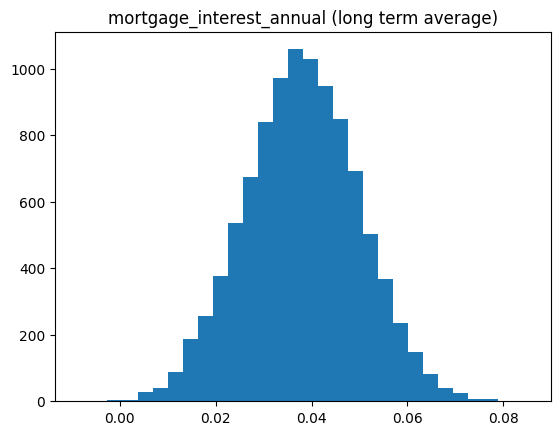

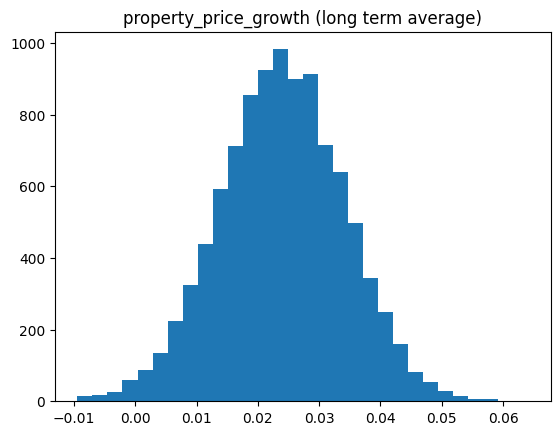

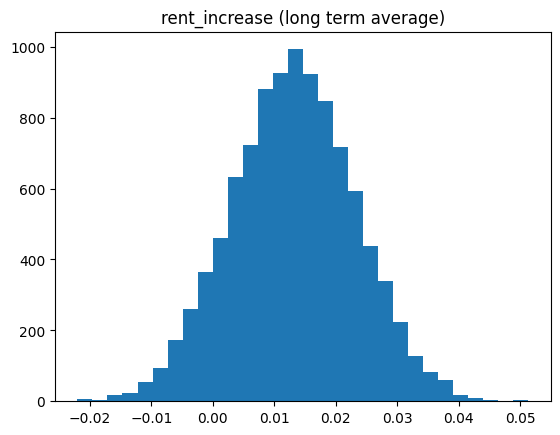

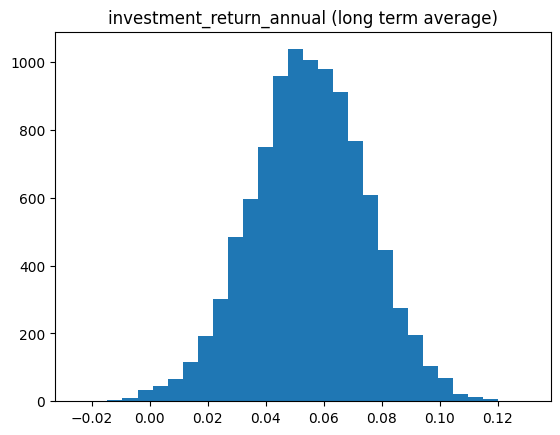

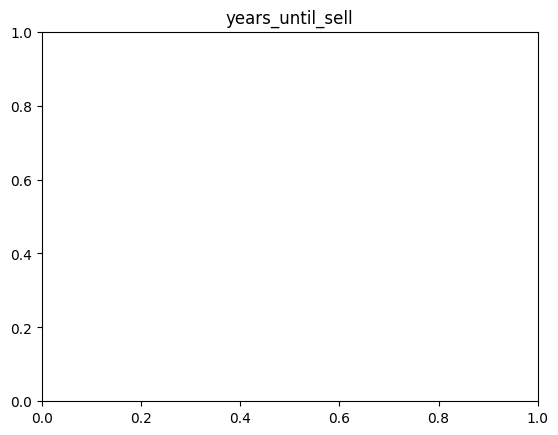

In [510]:
n_samples = 10000
n_bins = 30

plt.title('mortgage_interest_annual (long term average)')
mortgage_interest_annual_list = get_param_distribution(0.038, 0.012, n_samples,n_bins)
plt.title('property_price_growth (long term average)')
# mortgage_interest_annual_list = get_param_distribution(0.02, 0.01, 10000,30)
property_price_growth_annual_list = get_param_distribution(0.024, 0.01, n_samples,n_bins)
plt.title('rent_increase (long term average)')
rent_increase_list = get_param_distribution(0.01325 , 0.01, n_samples,n_bins)
plt.title('investment_return_annual (long term average)')
investment_return_annual_list = get_param_distribution(0.055, 0.02, n_samples,n_bins)
plt.title('years_until_sell')
years_until_sell_list =  [40]# get_param_distribution(15, 5, n_samples,n_bins, as_int = True) #[5,10,15,20,25]

Capital Invested: £400000.00
NPV mean: £171540.04
NPV mean (as % of invested capital): 42.89%
NPV std: £483889.88
NPV std (as % of invested capital): 120.97%
NPV skew: 3.01
Make money: 56.26% of the time


,Percentile,NPV,% return
0,10.000000,-220679.077244,-55.169769
1,25.000000,-110805.415498,-27.701354
2,50.000000,43093.718040,10.773430
3,75.000000,289636.103815,72.409026
4,90.000000,678892.109640,169.723027
5,43.743744,89.036774,0.022259


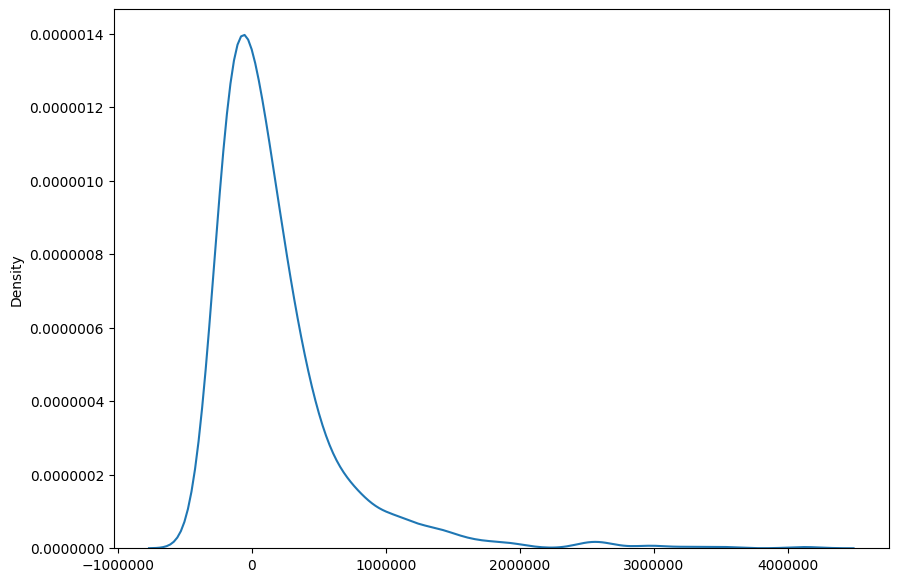

In [511]:
model = Buy_or_Rent_Model()
model.DEPOSIT_MULT = 0.5

results_df=generate_combinations_and_calculate_npv( 
                                                1000,
                                                model,
                                                mortgage_interest_annual_list=mortgage_interest_annual_list,
                                                property_price_growth_annual_list=property_price_growth_annual_list,
                                                rent_increase_list=rent_increase_list,
                                                investment_return_annual_list=investment_return_annual_list,
                                                years_until_sell_list=years_until_sell_list)

In [494]:
results_df.corr()

,buying_npv,mortgage_interest_annual,property_price_growth_annual,rent_increase,investment_return_annual,years_until_sell
buying_npv,1.000000,-0.288163,0.441658,0.137310,-0.693374,0.121079
mortgage_interest_annual,-0.288163,1.000000,-0.003983,0.027695,-0.004116,-0.006385
property_price_growth_annual,0.441658,-0.003983,1.000000,-0.035141,-0.017027,0.037720
rent_increase,0.137310,0.027695,-0.035141,1.000000,-0.032061,-0.001103
investment_return_annual,-0.693374,-0.004116,-0.017027,-0.032061,1.000000,0.012999
years_until_sell,0.121079,-0.006385,0.037720,-0.001103,0.012999,1.000000


In [512]:
def graph_kde_plots(results_df, FEATURES, num_cols = 3):
    
    # Calculate the number of rows and columns needed for subplots
    num_features = len(FEATURES)
    
    num_rows = (num_features + num_cols - 1) // num_cols

    # Create a figure and axis for subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten the axes if necessary (in case there's only one row)
    if num_rows == 1:
        axes = axes.reshape(1, -1)

    # Loop through each feature and plot it
    for i, feature in enumerate(FEATURES):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        
        sns.kdeplot(data=results_df, y="buying_npv", x=feature, ax=ax, fill=True)
        ax.set_title(f"{feature} vs. buying_npv")
        ax.set_ylabel("buying_npv")
        ax.set_xlabel(feature)
         # Calculate the 95th percentile for x and y axes
        x_low_percentile = np.percentile(results_df[feature], 0.5)
        y_low_percentile = np.percentile(results_df['buying_npv'], 0.5)
        x_high_percentile = np.percentile(results_df[feature], 99.5)
        y_high_percentile = np.percentile(results_df['buying_npv'], 99.5)
        
        # Set the axis limits based on the 95th percentile
        ax.set_xlim(x_low_percentile, x_high_percentile)
        ax.set_ylim(y_low_percentile, y_high_percentile)
        
        # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed
        
    # Remove any empty subplots
    for i in range(len(FEATURES), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

C:\Users\Edison Yi\AppData\Local\Temp\ipykernel_9544\2758553482.py:21: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=results_df, y="buying_npv", x=feature, ax=ax, fill=True)
C:\Users\Edison Yi\AppData\Local\Temp\ipykernel_9544\2758553482.py:32: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(x_low_percentile, x_high_percentile)


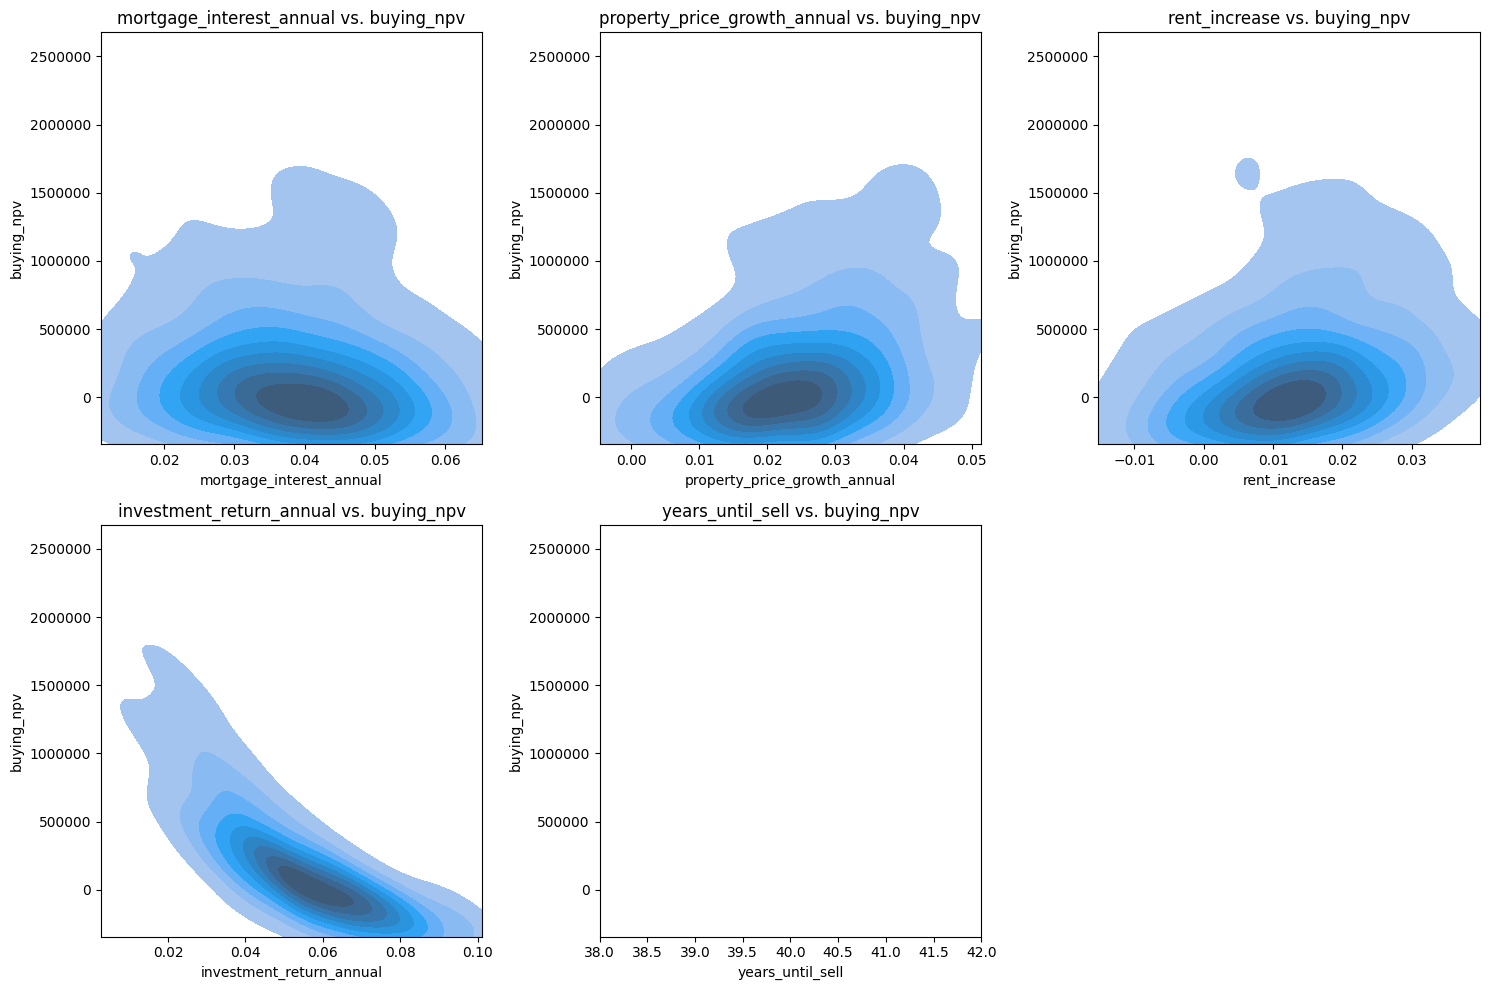

In [513]:
FEATURES = ['mortgage_interest_annual', 'property_price_growth_annual', 'rent_increase', 'investment_return_annual', 'years_until_sell']
graph_kde_plots(results_df, FEATURES, num_cols = 3)

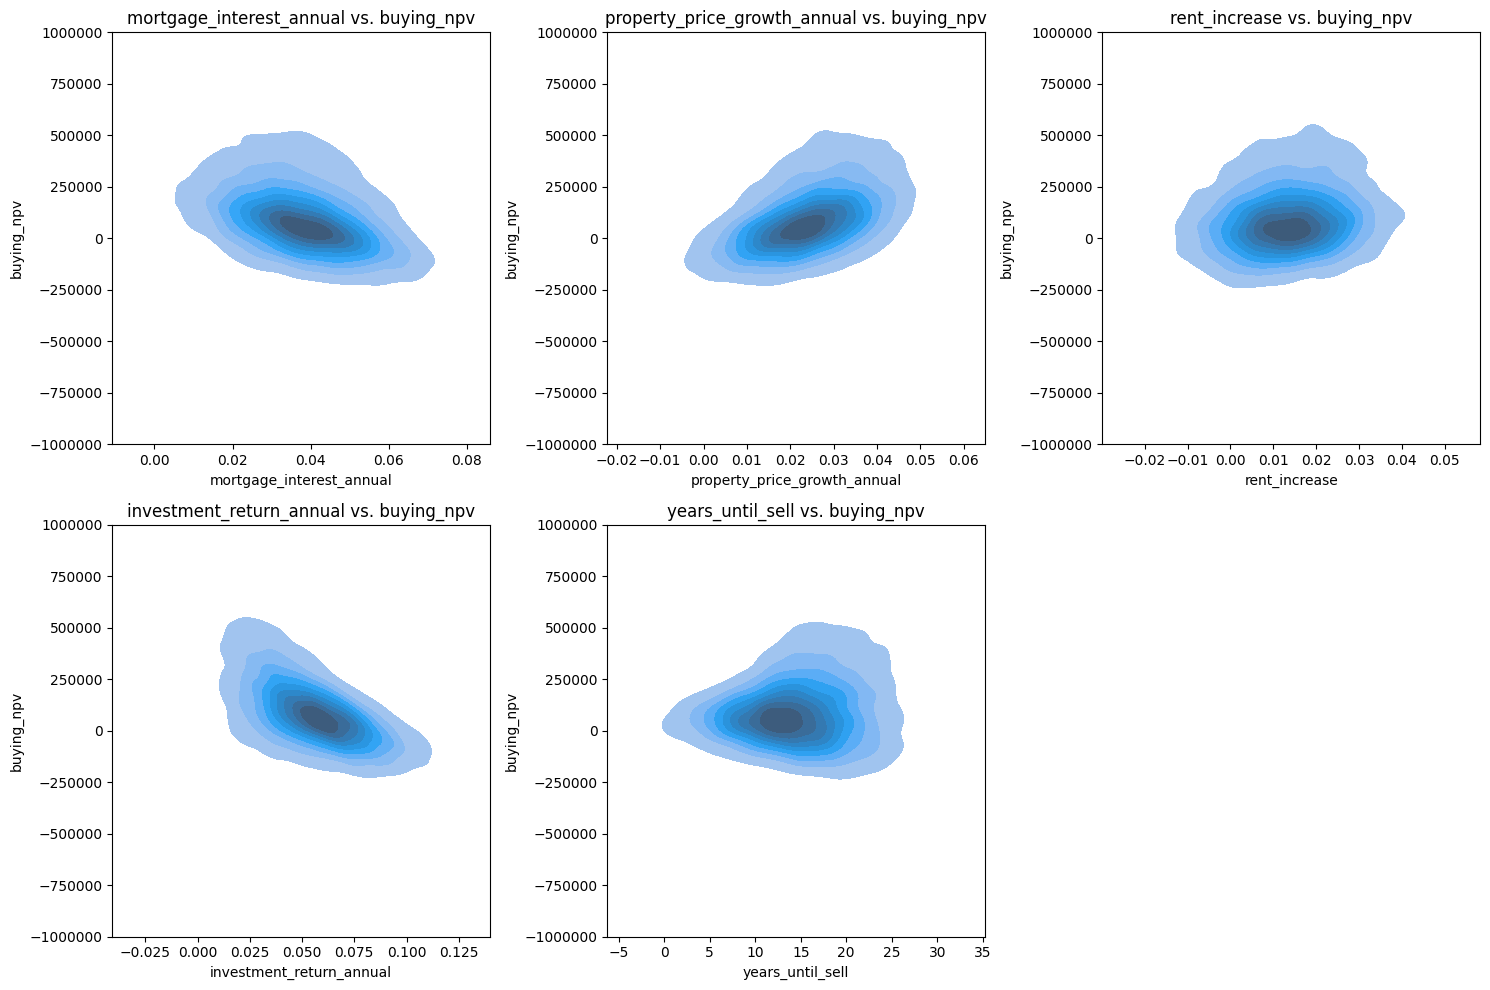

In [454]:
FEATURES = ['mortgage_interest_annual', 'property_price_growth_annual', 'rent_increase', 'investment_return_annual', 'years_until_sell']

# Calculate the number of rows and columns needed for subplots
num_features = len(FEATURES)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

# Create a figure and axis for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes if necessary (in case there's only one row)
if num_rows == 1:
    axes = axes.reshape(1, -1)

# Loop through each feature and plot it
for i, feature in enumerate(FEATURES):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    sns.kdeplot(data=results_df, y="buying_npv", x=feature, ax=ax, fill=True)
    ax.set_title(f"{feature} vs. buying_npv")
    ax.set_ylabel("buying_npv")
    ax.set_xlabel(feature)
    ax.set_ylim(-1000000,1000000)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed
    
# Remove any empty subplots
for i in range(len(FEATURES), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [409]:
bin_config = {
    'mortgage_interest_annual':3, 
    'property_price_growth_annual':3, 
    'rent_increase':3, 
    'investment_return_annual':3, 
    'years_until_sell':3
}
results_df=bin_continuous_features(results_df,bin_config)